In [37]:

import json
import pandas as pd
import numpy as np
from toolz import memoize
import datetime
import math

from tqdm import tqdm
from src.utils.mouselab_jas import MouselabJas
from src.utils.distributions import Normal, expectation
from src.utils.env_creation import create_tree, create_init
from src.utils.env_export import create_json
from src.utils.data_classes import MouselabConfig, Action
from simulation import run_simulation
from src.policy.jas_voc_policy import JAS_voc_policy
from src.policy.jas_policy import RandomPolicy, ExhaustivePolicy, RandomNPolicy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from src.utils.utils import sigma_to_tau
import numpy as np
from src.utils.env_export import format_payoff
from src.utils.khalili_env import get_env


sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.5)
sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
data = json.load(open("./data/dataclips_5.json"))

In [39]:
language_index = data["fields"].index("language")
response_data_index = data["fields"].index("datastring")
begin_index = data["fields"].index("beginhit")
end_index = data["fields"].index("endhit")

f = '%Y-%m-%d %H:%M:%S.%f'

In [40]:
# Fixed from paper
env, config = get_env(5, term_belief=False)
voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=0.5798921379230035)

In [41]:
def convert_action(project: int, criteria: int, expert: int, config: MouselabConfig) -> Action:
    query = (1 + criteria) + project*config.num_criterias
    action = Action(expert=expert, query=query)
    return action

In [42]:
# Check survey responses, filter participants that respond "No" to the attention question

exclude_answers = ["no"]
known_workers = []
excluded = []
quiz_excluded = 0

# Parse raw mturk data into dataframe
for p_index, p_data in tqdm(enumerate(data["values"])):
    # Filter out empty responses
    response_data = p_data[response_data_index]
    if (response_data != None):
        p_res_obj = json.loads(response_data)
        if (not p_res_obj["workerId"].startswith("debug")):
            worker = p_index #p_res_obj["workerId"]#p_index # 
            if worker in known_workers:
                print("Duplicate worker", worker)
            else: 
                known_workers.append(worker)
            p_res = p_res_obj["data"]
            if "quiz_failures" in p_res_obj["questiondata"].keys():
                quiz_failures = p_res_obj["questiondata"]["quiz_failures"]
            else:
                quiz_failures = 0
            completed_test_trials = sum([1 if ('trial_id' in  p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test")) else 0 for i in range(len(p_res))])
            if quiz_failures >= 3:
                quiz_excluded += 1
            elif (quiz_failures < 3) and (completed_test_trials == 10):
                for i in range(len(p_res)):
                    # Get test trials
                    if p_res[i]['trialdata']["trial_type"] == "survey-text":
                        attention_response: str = p_res[i]['trialdata']["response"]["Reward"].lower()
                        if any([attention_response.startswith(answer) for answer in exclude_answers]):
                            print("Exclude", worker, attention_response)
                            excluded.append(worker)

print("Quiz exclusions", quiz_excluded)
print("Effort question exclusions", len(excluded))

385it [00:00, 1406.58it/s]

Exclude 168 not really
Exclude 248 not really
Exclude 283 no
Quiz exclusions 10
Effort question exclusions 3


In [43]:
df_index = ["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "Actions", "Selection",
        "Seed", "ClickAgreement"]    
df_all_data = [] # With excluded to calculate bonus payments
df_data = []

bonus_data = {}
known_workers = []
good_responses = 0
demographics = []

participant_actions = []

# Parse raw mturk data into dataframe
for p_index, p_data in tqdm(enumerate(data["values"])):
    # Filter out empty responses
    language = p_data[language_index]
    response_data = p_data[response_data_index]
    if p_data[begin_index] and p_data[end_index]:
        begin = datetime.datetime.strptime(p_data[begin_index], f)
        end = datetime.datetime.strptime(p_data[end_index], f)
        duration = (end - begin).total_seconds()
    else:
        duration = None
    if (response_data != None):
        p_res_obj = json.loads(response_data)
        if (not p_res_obj["workerId"].startswith("debug")):
            condition = p_res_obj["condition"]
            worker = p_index #p_res_obj["workerId"]# 
            if worker in known_workers:
                print("Duplicate worker", worker)
            else: 
                known_workers.append(worker)
            p_res = p_res_obj["data"]
            participant_responses = []
            if "quiz_failures" in p_res_obj["questiondata"].keys():
                quiz_failures = p_res_obj["questiondata"]["quiz_failures"]
            else:
                quiz_failures = 0
            if "final_bonus" in p_res_obj["questiondata"].keys():
                bonus =  p_res_obj["questiondata"]["final_bonus"]
            else:
                bonus = 0
            participant_survey = {"Participant": worker, "Condition": condition, "Language": language, "QuizAttempts": 0, "QuizFailures": quiz_failures, "Bonus": bonus, "Duration": duration}
            completed_test_trials = sum([1 if ('trial_id' in  p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test")) else 0 for i in range(len(p_res))])
            if (quiz_failures < 3) and (completed_test_trials == 10):
                for i in range(len(p_res)):
                    # Get test trials
                    if 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test"):
                        trial_id = p_res[i]['trialdata']['trial_id']
                        seed = int(p_res[i]['trialdata']['seed'])
                        ground_truth = p_res[i]['trialdata']['ground_truth']
                        # project, criteria, expert
                        clicks = p_res[i]['trialdata']["clicks"]
                        num_clicks = len(clicks)
                        selected_project = p_res[i]['trialdata']["selected_project"]
                        term_reward = p_res[i]['trialdata']["reward"]
                        expected_reward = p_res[i]['trialdata']["expected_reward"]
                        # Calculate real env rewards
                        env.reset(seed=seed)
                        actions = [convert_action(*click, config) for click in clicks]
                        participant_actions.extend(actions)
                        cost = 0
                        # Click agreement
                        click_agreement = []
                        for action in actions:
                            optimal_actions = voc_policy.get_best_actions(env, eps=0.001)
                            if action in optimal_actions:
                                click_agreement.append(1)
                            else:
                                click_agreement.append(0)
                            _, reward, _, _ = env.step(action)
                            cost += reward
                        optimal_actions = voc_policy.get_best_actions(env)
                        if env.term_action in optimal_actions:
                            click_agreement.append(1)
                        else:
                            click_agreement.append(0)
                        path = np.array(range(1, config.num_criterias+1))+(selected_project*config.num_criterias)
                        env_expected_reward = cost + env.expected_path_value(path, env.state)
                        env_term_reward = cost + env.path_value(path)
                        assert np.all(np.isclose(ground_truth, env.ground_truth.tolist()))
                        assert np.all(np.isclose(np.array(format_payoff(config.num_projects, config.num_criterias, env.expert_truths.tolist())), p_res[i]['trialdata']['payoff_matrix']))
                        assert np.isclose(term_reward, env_term_reward)
                        assert np.isclose(expected_reward, env_expected_reward)
                        
                        #["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "Actions", "Selection", "Seed", "ClickAgreement"]  
                        if worker not in excluded:
                            df_data.append([worker, condition, trial_id, term_reward, expected_reward, num_clicks, clicks, selected_project, seed, np.mean(click_agreement)])
                        df_all_data.append([worker, condition, trial_id, term_reward, expected_reward, num_clicks, clicks, selected_project, seed, np.mean(click_agreement)])
                    elif 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("train"):
                        pass
                    elif p_res[i]['trialdata']["trial_type"] == "survey-text":
                        pass
                    

df = pd.DataFrame(df_data, columns=df_index)
df_all = pd.DataFrame(df_all_data, columns=df_index)
print("Responses:", len(df["Participant"].unique()))
print("Responseswith excluded :", len(df_all["Participant"].unique()))

385it [40:35,  6.33s/it]

Responses: 298
Responseswith excluded : 301


In [44]:
df.groupby("Participant").mean()

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_20640\2616027.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Participant").mean()


,Condition,Score,ExpectedScore,NumClicks,Selection,Seed,ClickAgreement
Participant,,,,,,,
0,0.0,3.887710,3.634325,5.0,2.4,16.5,0.316667
1,1.0,3.582799,3.465661,4.0,1.5,16.5,0.175000
2,2.0,3.819524,3.548929,3.4,2.0,16.5,0.250000
4,2.0,3.208749,3.418823,3.4,1.9,16.5,0.115000
6,0.0,3.873925,3.741854,4.7,2.1,16.5,0.683333
...,...,...,...,...,...,...,...
379,0.0,3.735126,3.700479,4.4,1.7,16.5,0.430000
380,0.0,3.717647,3.670769,5.0,2.1,16.5,0.583333
381,0.0,3.680862,3.610198,5.0,2.6,16.5,0.383333


In [45]:
participant_scores = df_all.groupby("Participant").agg(["mean", "std"])
participant_scores = participant_scores.sort_values(("Score", "mean"), ascending=False)
participant_scores

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_20640\1414525899.py:1: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  participant_scores = df_all.groupby("Participant").agg(["mean", "std"])


Condition          Score           ExpectedScore            \
                 mean  std      mean       std          mean       std   
Participant                                                              
293               1.0  0.0  4.198191  0.521779      3.660236  0.107887   
75                2.0  0.0  4.171736  0.540657      3.729907  0.037723   
225               1.0  0.0  4.159595  0.541685      3.697053  0.085047   
210               1.0  0.0  4.155702  0.403269      3.714527  0.093303   
266               1.0  0.0  4.148768  0.416167      3.724769  0.030657   
...               ...  ...       ...       ...           ...       ...   
226               0.0  0.0  3.068694  0.899954      3.369509  0.113367   
215               0.0  0.0  3.063188  0.444662      3.029154  0.283073   
361               0.0  0.0  3.057655  1.130552      3.406485  0.016826   
90                2.0  0.0  3.020367  1.194276      3.401241  0.007475   
370               2.0  0.0  2.851281  0.935422      3.050600  0.304528   

            NumClicks           Selection            Seed           \
                 mean       std      mean       std  mean      std   
Participant                                                          
293               4.5  0.527046       2.0  1.333333  16.5  3.02765   
75                4.8  0.632456       1.5  1.269296  16.5  3.02765   
225               4.9  0.316228       2.4  1.429841  16.5  3.02765   
210               3.6  0.966092       1.8  1.135292  16.5  3.02765   
266               5.0  0.000000       2.5  1.433721  16.5  3.02765   
...               ...       ...       ...       ...   ...      ...   
226               2.2  0.632456       0.7  0.483046  16.5  3.02765   
215               4.9  0.316228       1.9  1.523884  16.5  3.02765   
361               0.3  0.948683       2.0  1.490712  16.5  3.02765   
90                1.6  0.699206       1.3  1.159502  16.5  3.02765   
370               3.4  1.173788       2.4  1.349897  16.5  3.02765   

            ClickAgreement            
                      mean       std  
Participant                           
293               0.266667  0.169967  
75                0.375000  0.205067  
225               0.490000  0.224461  
210               0.668333  0.268679  
266               0.500000  0.260579  
...                    ...       ...  
226               0.040000  0.126491  
215               0.490000  0.285038  
361               0.000000  0.000000  
90                0.000000  0.000000  
370               0.330000  0.204547  

[301 rows x 14 columns]

In [46]:
sorted_participants = participant_scores.index.tolist()
half_participants = math.ceil(len(sorted_participants)/2)
high_bonus = sorted_participants[:half_participants]
low_bonus = sorted_participants[half_participants:]
for id in high_bonus:
    print(f"{id},0.75")
for id in low_bonus:
    print(f"{id},0.25")

293,0.75
75,0.75
225,0.75
210,0.75
266,0.75
7,0.75
205,0.75
44,0.75
250,0.75
31,0.75
312,0.75
344,0.75
324,0.75
307,0.75
165,0.75
333,0.75
82,0.75
28,0.75
240,0.75
358,0.75
85,0.75
280,0.75
180,0.75
172,0.75
217,0.75
276,0.75
195,0.75
367,0.75
354,0.75
15,0.75
302,0.75
359,0.75
308,0.75
321,0.75
89,0.75
216,0.75
288,0.75
65,0.75
212,0.75
118,0.75
51,0.75
178,0.75
181,0.75
126,0.75
234,0.75
24,0.75
166,0.75
84,0.75
222,0.75
204,0.75
34,0.75
56,0.75
223,0.75
96,0.75
29,0.75
338,0.75
262,0.75
48,0.75
151,0.75
268,0.75
383,0.75
171,0.75
373,0.75
169,0.75
260,0.75
335,0.75
343,0.75
197,0.75
190,0.75
346,0.75
186,0.75
349,0.75
193,0.75
112,0.75
130,0.75
177,0.75
340,0.75
52,0.75
9,0.75
364,0.75
313,0.75
120,0.75
184,0.75
156,0.75
331,0.75
162,0.75
0,0.75
272,0.75
353,0.75
140,0.75
11,0.75
6,0.75
122,0.75
378,0.75
257,0.75
237,0.75
78,0.75
264,0.75
125,0.75
294,0.75
183,0.75
131,0.75
301,0.75
279,0.75
214,0.75
352,0.75
128,0.75
285,0.75
98,0.75
292,0.75
368,0.75
213,0.75
366,0.75
2,0.75
164,0

In [47]:
df.to_csv("./data/experiment_results/exp_5.csv")

In [48]:
df = pd.read_csv("./data/experiment_results/exp_5.csv")

In [51]:
df.groupby("Condition").agg(["mean", "std"]).round(4)[["ExpectedScore", "ClickAgreement"]]

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_20640\1255232272.py:1: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("Condition").agg(["mean", "std"]).round(4)[["ExpectedScore", "ClickAgreement"]]


ExpectedScore         ClickAgreement        
                   mean     std           mean     std
Condition                                             
0                3.5176  0.1973         0.2521  0.2777
1                3.5858  0.1903         0.4271  0.3211
2                3.5265  0.1922         0.2664  0.2547

<AxesSubplot: xlabel='Condition', ylabel='ClickAgreement'>

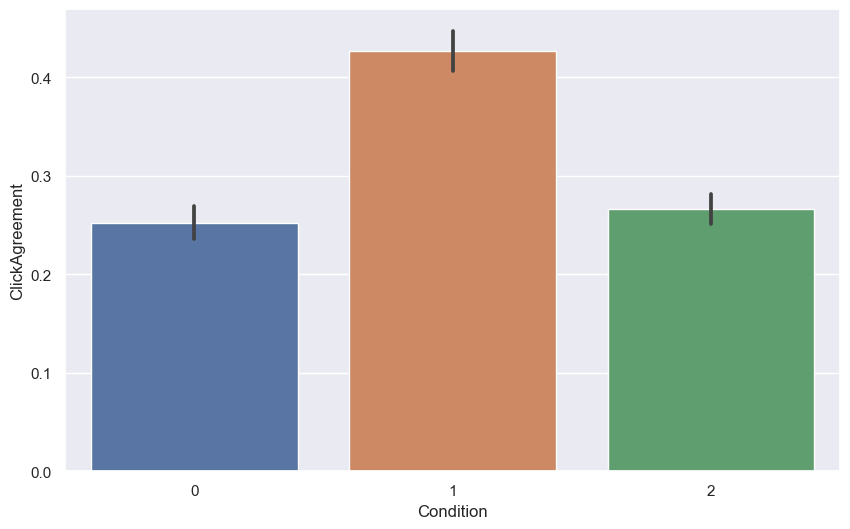

In [49]:
sns.barplot(df, y="ClickAgreement", x="Condition")

(3.3, 3.7)

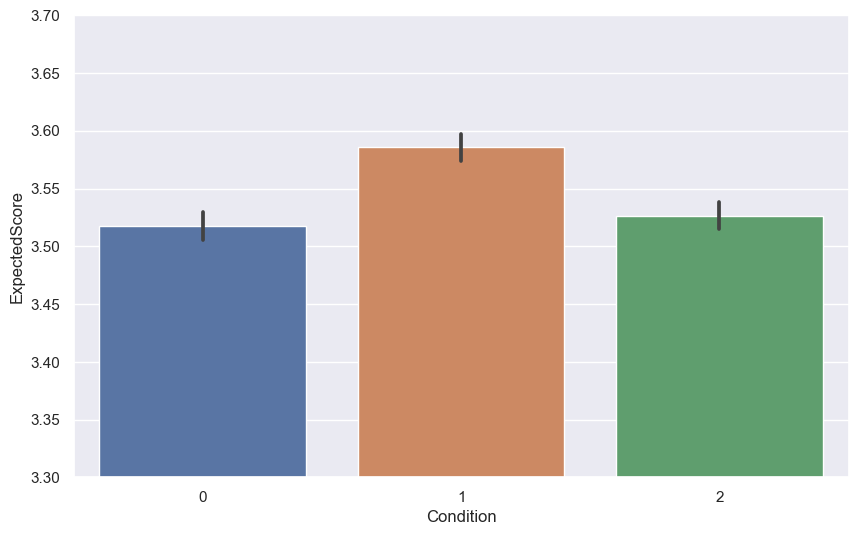

In [50]:
g = sns.barplot(df, y="ExpectedScore", x="Condition")
g.set_ylim(3.3, 3.7)